In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print(raw_kin_df.shape[0], 'total WT RuBisCOs')
print(kin_df.shape[0], 'RuBisCOs with all core kinetic data measured')

347 total WT RuBisCOs
200 RuBisCOs with all core kinetic data measured


In [4]:
# kon_O vs kon_C
kon_Os = np.log(raw_kin_df.kon_O)
kon_Cs = np.log(raw_kin_df.kon_C)

print('Whole dataset correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

fIs = raw_kin_df[raw_kin_df.isoform == '1']
kon_Os = np.log(fIs.kon_O)
kon_Cs = np.log(fIs.kon_C)

print('FI dataset correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

kon_Os = np.log(savir_df.kon_O)
kon_Cs = np.log(savir_df.kon_C)

print('Savir correlation')
r, p = power_laws.log_pearsonr(kon_Os, kon_Cs)
print('Log-scale linear regression R = %.2f, P = %.2g' % (r, p))
print('Spearman rank correlation R = %.2f, P = %.2g' % power_laws.log_spearmanr(kon_Os, kon_Cs))

Whole dataset correlation
Log-scale linear regression R = 0.64, P = 5.7e-23
Spearman rank correlation R = 0.85, P = 5.7e-54
FI dataset correlation
Log-scale linear regression R = 0.93, P = 6e-82
Spearman rank correlation R = 0.93, P = 4.9e-81
Savir correlation
Log-scale linear regression R = 0.58, P = 0.02
Spearman rank correlation R = 0.49, P = 0.057


In [5]:
# Bootstrapped regression over the FI rubiscos

# konC = vC/KC (both measured)
# konO = vO/KO (vO not measured)
# S = vC/KC / (vO/KO)
# Therefore,
# vO = vC/KC / (S/KO) and
# konO = vC/KC / (S/KO) / (KO) = vC/(S KC)

all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
fraction = 0.9
tot = all_FIs.kon_C.size
subset_size = int(fraction * tot)

runs = 10000
exponents = []
prefactors = []
prefactors_1 = []
rvals = []
for _ in range(runs):
    idxs = np.random.choice(tot, subset_size)
    subset = all_FIs.iloc[idxs]
    
    # Make kcatC/KC sample
    vC_vals = subset.vC
    KC_vals = subset.KC
    konC_vals = vC_vals / KC_vals

    # kcatO/KO sample
    S_vals = subset.S
    konO_vals = vC_vals / KC_vals / S_vals
    
    log_konC = np.log(konC_vals)
    log_konO = np.log(konO_vals)
    
    # Fit a power law.
    exp, pre, rval = power_laws.fit_power_law_odr(log_konO, log_konC)
    exponents.append(exp)
    prefactors.append(pre)
    rvals.append(rval)
    
    # Fit a power law with exp = 1.0
    exp, pre, _ = power_laws.fit_power_law_odr(log_konO, log_konC, unit_exp=True)
    prefactors_1.append(pre)

In [6]:
conf_range = [2.5, 97.5]
pre_interval = np.percentile(prefactors, conf_range)
exp_interval = np.percentile(exponents, conf_range)
rs_interval = np.percentile(rvals, conf_range)
pre1_interval = np.percentile(prefactors_1, conf_range)

print('exponent 95% CI', exp_interval)
print('prefactor 95% CI', pre_interval)
print('R 95% CI', rs_interval)
print('prefactor 95% CI assuming exp=1.0', pre1_interval)


exponent 95% CI [1.00603277 1.22032535]
prefactor 95% CI [ 96.80345119 358.33511866]
R 95% CI [0.88454061 0.94992517]
prefactor 95% CI assuming exp=1.0 [89.44062711 94.73822258]


[ 96.80345119 358.33511866]
[1.00603277 1.22032535]


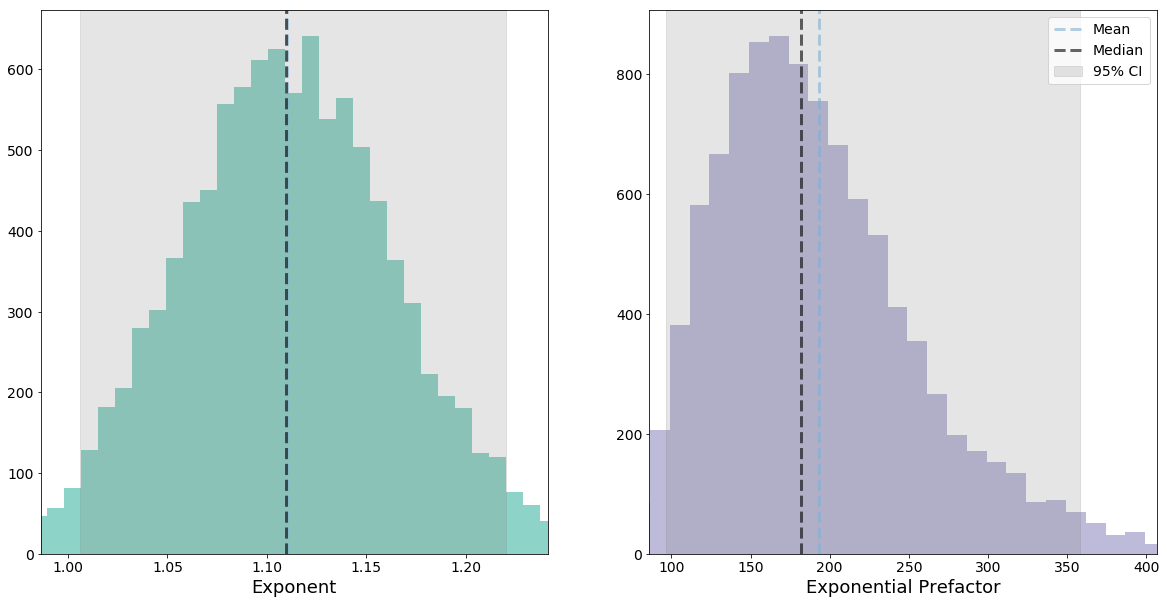

In [7]:
power_laws.plot_bootstrapped_range(exponents, prefactors)

In [8]:
# Regress on savir data to get previous fit. 
# NOTE: 1. Savir drops the FII Rubiscos for this fit, I think. Unclear from text if he dropped both or one.
# NOTE: 2. Can't reproduce his exponent of 0.5. I get 0.77. 
savir_FI = savir_df[savir_df.isoform == '1']

konOs = np.log(savir_FI.kon_O)
konCs = np.log(savir_FI.kon_C)
exp_savir, pre_savir, r = power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False)
print(exp_savir, pre_savir, r)

1.2944903398783167 452.61821295245875 0.8402123935868826


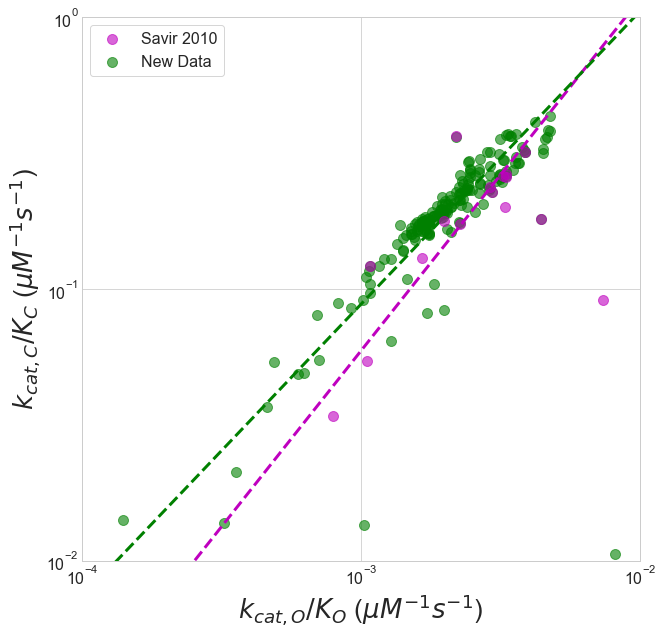

In [9]:
# Mechanistic proposal #2 from Savir 2010 - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

# Regress against FI data, which is closest to the front. 
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
exp_allFI, pre_allFI, r = power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False)

plt.xscale('log')
plt.yscale('log')

plt.scatter(savir_df.kon_O, savir_df.kon_C, c='m', s=100, label='Savir 2010', zorder=10, alpha=0.6)
plt.scatter(nonsavir_df.kon_O, nonsavir_df.kon_C, c='g', s=100, label='New Data', alpha=0.6)

xs = np.arange(1e-4, 2e-2, 0.01)
plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='m', lw=3, ls='--')
plt.plot(xs, np.power(xs, exp_allFI)*pre_allFI, c='g', lw=3, ls='--')

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig6/fig6_konC_konO.png', dpi=600)
plt.savefig('fig6/fig6_konC_konO.svg')

plt.show()

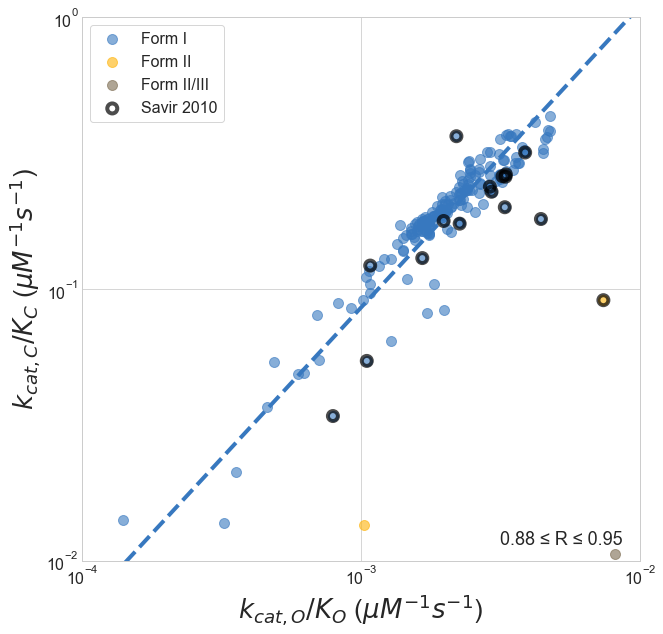

In [10]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

groups = {'1': 'I', 
          '2': 'II',
          '2_3': 'II/III', 
          '3': 'III'}

for i, (group, gdf) in enumerate(grouped_form):
    if group == '3':
        continue
    label = 'Form %s' % groups[group]
    c = matplotlib.colors.rgb2hex(named_colors[i])
    plt.scatter(gdf.kon_O, gdf.kon_C,  c=c, s=100, label=label, alpha=0.6)

# Plot our regression and CI
xs = np.arange(1e-4, 2e-2, 0.01)
c = matplotlib.colors.rgb2hex(named_colors[0])
power_laws.plot_bootstrapped_ci(xs, exponents, prefactors, figure=figure, color=c,
                                lw=4, plot_range=False)

# Savir power law, inferred
#plt.plot(xs, np.power(xs, exp_savir)*pre_savir, c='grey', lw=2, ls='--')

# Show savir data with an outline
plt.scatter(savir_df.kon_O, savir_df.kon_C, c='None', edgecolors='k',
            linewidths=4, s=100, label='Savir 2010', alpha=0.7, zorder=10)
plt.text(0.75, 0.03, u'%.2f ≤ R ≤ %.2f' % (rs_interval[0], rs_interval[1]), 
         transform=figure.axes[0].transAxes, fontsize=18)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig6/fig6_konC_konO_FI.png', dpi=600)
plt.savefig('fig6/fig6_konC_konO_FI.svg')

plt.show()

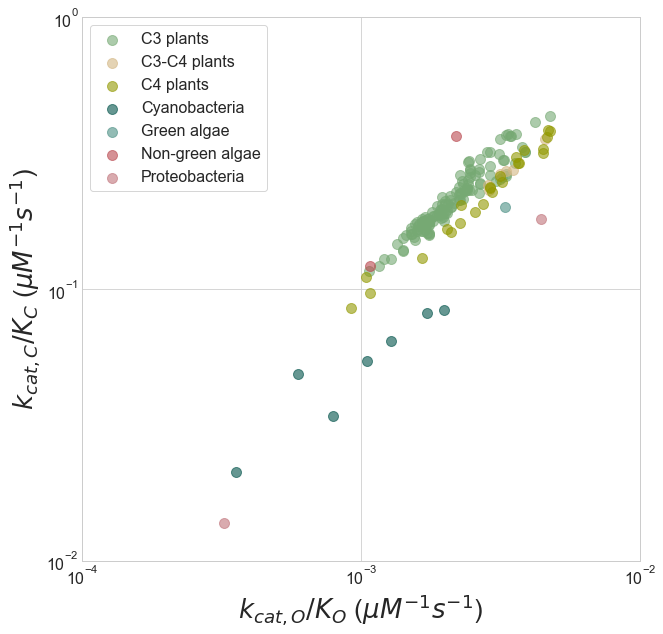

In [11]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC color by isoform
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

F1_data = raw_kin_df[raw_kin_df.isoform == '1']
F2_data = raw_kin_df[raw_kin_df.isoform == '2']
F23_data = raw_kin_df[raw_kin_df.isoform == '2_3']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Non-green algae': 'Non-green algae',
                 'Alphaproteobacteria': 'Proteobacteria',
                 'Betaproteobacteria': 'Proteobacteria',
                 'Gammaproteobacteria': 'Proteobacteria',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Non-green algae': 'dusty red',
    'Proteobacteria': 'dusty rose',
    'Form II':  "amber", 
    'Form II/III': "greyish brown",
}
grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

for i, (group, gdf) in enumerate(grouped_taxa):   
    cname = color_mapping[group]
    c = seaborn.xkcd_rgb[cname]
    plt.scatter(gdf.kon_O, gdf.kon_C, c=c, s=100, label=group, alpha=0.6)
    

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-4, 1e-2)
plt.ylim(1e-2, 1)

plt.savefig('fig6/fig6_konC_konO_FI_by_group.png', dpi=600)
plt.savefig('fig6/fig6_konC_konO_FI_by_group.svg')

plt.show()

In [12]:
all_FIs = raw_kin_df[raw_kin_df.isoform == '1']
konOs = np.log(all_FIs.kon_O)
konCs = np.log(all_FIs.kon_C)
print('Free exp')
print(power_laws.fit_power_law_odr(konOs, konCs, unit_exp=False))

print('exponent=1.0')
print(power_laws.fit_power_law_odr(konOs, konCs, unit_exp=True))

Free exp
(1.077890566600616, 150.43706574857217, 0.9300738669882745)
exponent=1.0
(1, 92.7431222119451, 0.9300738669882747)


In [13]:
for i, (group, gdf) in enumerate(grouped_taxa):   
    # Only use points that have data - bootstrapping will work right now.
    mask = gdf.kon_O.notnull() & gdf.kon_C.notnull()
    size = mask.sum()
    masked_gdf = gdf[mask]
    
    print(group)
    print('%d data points' % size)
    if size < 7:
        print('Not enough data')
        print()
        continue
        
    exps, pres, rs = power_laws.bootstrap_power_law_odr(masked_gdf.kon_O, masked_gdf.kon_C, rounds=1000)
    
    ci = 0.95
    ci_end = (1.0 - ci)/2.0
    conf_range = [100-100*ci_end, 100*ci_end]
    pre_interval = np.percentile(pres, conf_range)
    exp_interval = np.percentile(exps, conf_range)
    rs_interval = np.percentile(rs, conf_range)
    
    print('exponent 95% ci:', exp_interval)
    print('prefactor 95% ci:', pre_interval)
    print('pearson R 95% ci:', rs_interval)
    print()

C3 plants
128 data points
exponent 95% ci: [0.98374886 0.86886892]
prefactor 95% ci: [91.45885922 44.11841827]
pearson R 95% ci: [0.96941382 0.94091245]

C3-C4 plants
6 data points
Not enough data

C4 plants
24 data points
exponent 95% ci: [1.02118732 0.81589361]
prefactor 95% ci: [90.77173667 27.52071135]
pearson R 95% ci: [0.99497848 0.97697732]

Cyanobacteria
7 data points
exponent 95% ci: [1.10271897 0.4582685 ]
prefactor 95% ci: [98.79191626  1.4445469 ]
pearson R 95% ci: [0.99975517 0.69129374]

Green algae
1 data points
Not enough data

Non-green algae
2 data points
Not enough data

Proteobacteria
2 data points
Not enough data

